In [1]:
!pip install --upgrade pip
!pip install SimPEG
!pip install pymatsolver

Requirement already up-to-date: pip in /home/nbcommon/anaconda3_431/lib/python3.6/site-packages


In [99]:
# Basic python packages
import numpy as np 
import matplotlib.pyplot as plt
from scipy.constants import mu_0

import ipywidgets
from matplotlib.colors import LogNorm

# Modules of SimPEG we will use for forward modelling
from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import FDEM
from pymatsolver import Pardiso as Solver

%matplotlib inline

## model parameters

Here, we define a model consisting of a uniform background, and a target

In [63]:
sigma_wholespace = 1e-3
sigma_target = 1

mur_wholespace = 1
mur_target = 1

In [132]:
# semi-axes of the target
radius_a = 20  # horizontal axis
radius_c = 20  # vertical axis 

In [133]:
freqs = np.logspace(1, 4, 4)
print(freqs)

[    10.    100.   1000.  10000.]


In [134]:
# print the min and max skin depths to make sure mesh is fine enough and 
# extends far enough 

def skin_depth(sigma, f):
    return 500./np.sqrt(sigma * f)

print(
    'Minimum skin depth (in target): {:.2e} m '.format(skin_depth(sigma_target, freqs.max()))
)
print(
    'Maximum skin depth (in background): {:.2e} m '.format(skin_depth(sigma_wholespace, freqs.min()))
)

Minimum skin depth (in target): 5.00e+00 m 
Maximum skin depth (in background): 5.00e+03 m 


In [135]:
cs = 2.5 # core cell size
ncx = np.ceil(np.max([rad_a, rad_c]) * 20)
ncz = np.ceil(np.max([rad_a, rad_c]) * 40)
npadx = 25 
pf = 1.3 # padding factor

npadz = 25

hx = Utils.meshTensor([(cs, ncx), (cs, npadx, pf)])
hz = Utils.meshTensor([(cs, npadz, -pf), (cs, ncz), (cs, npadz, pf)])
mesh = Mesh.CylMesh([hx, 1, hz], x0='00C')

In [136]:
2.5*40

100.0

(-1000.0, 1000.0)

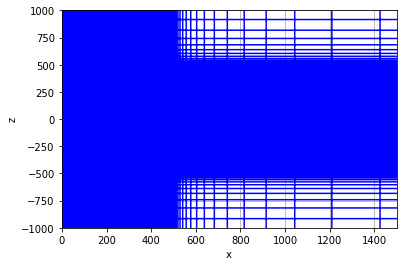

In [137]:
fig, ax = plt.subplots(1, 1)
mesh.plotGrid(ax=ax)
ax.set_xlim([-1., 1500.])
ax.set_ylim([-1000., 1000.])

In [138]:
print("total number of cells: {}".format(mesh.nC))

total number of cells: 101250


In [139]:
# put the model on the mesh
sigma_background = sigma_wholespace*np.ones(mesh.nC)
mur_background = mur_wholespace*np.ones(mesh.nC)

# ellipsoid
sigma = sigma_background.copy()
mur = mur_background.copy()

inds_ellipsoid = (mesh.gridCC[:,0]**2/rad_a**2 + mesh.gridCC[:,2]**2/rad_c**2) <= 1.

sigma[inds_ellipsoid] = sigma_target
mur[inds_ellipsoid] = mur_target

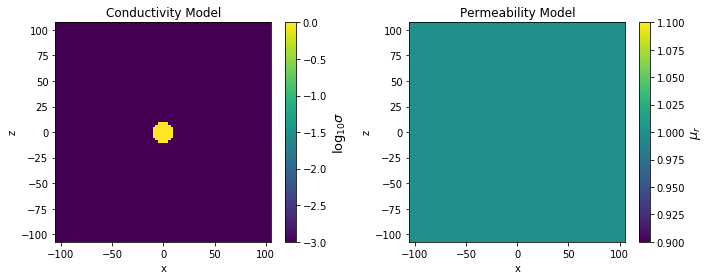

In [140]:
xlim = np.r_[-100., 100.]
ylim = np.r_[-100., 100]

# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,2, figsize=(10, 4))

# conductivity model
cb = plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax[0], mirror=True)[0], ax=ax[0])

# plot formatting and titles
cb.set_label('$\log_{10}\sigma$', fontsize=13)
ax[0].axis('equal')
ax[0].set_title('Conductivity Model')

# permeability model
cb = plt.colorbar(mesh.plotImage(mur, ax=ax[1], mirror=True)[0], ax=ax[1])

# plot formatting and titles
cb.set_label('$\mu_r$', fontsize=13)
ax[1].axis('equal')
ax[1].set_title('Permeability Model')

[a.set_xlim([-100., 100.]) for a in ax]
[a.set_ylim([-100., 100.]) for a in ax]

plt.tight_layout()

## set up the forward problem

In [141]:
# find the indices where we want to put the solenoid - it is on edges 
# (electric field is defined on cell edges for EB formulation)
solenoid_x = 1000
solenoid_zlims = np.r_[-2000., 2000.] # 1km long solenoid

solenoid_z = mesh.vectorNz[(mesh.vectorNz>=solenoid_zlims[0]) & (mesh.vectorNz<=solenoid_zlims[1])]

In [142]:
solenoid_inds = Utils.closestPoints(mesh, Utils.ndgrid([np.r_[solenoid_x], np.r_[0], solenoid_z]), 'Ey')
src_vec = np.zeros(mesh.nEy)
src_vec[solenoid_inds] = 1.

(-3000, 3000)

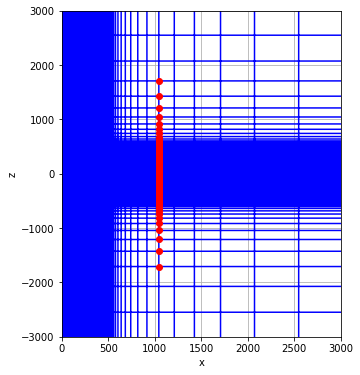

In [143]:
# plot it
fig, ax = plt.subplots(1,1, figsize=(5, 6))
mesh.plotGrid(ax=ax)
ax.plot(mesh.gridEy[solenoid_inds,0], mesh.gridEy[solenoid_inds, 2], 'ro')
ax.set_xlim([-1, 3e3])
ax.set_ylim([-3000, 3000])


In [144]:
rxList = [] # see FDEM.Rx for receiver types
srcList = [FDEM.Src.RawVec_e(rxList, f, src_vec) for f in freqs]

In [145]:
# define a problem - the statement of which discrete pde system we want to solve
wires = Maps.Wires(('sigma', mesh.nC), ('mu', mesh.nC)) # mapping to work with a vector m = [sigma, mu] as the model
prob = FDEM.Problem3D_e(mesh, sigmaMap=wires.sigma, muMap=wires.mu)  
prob.solver = Solver

survey = FDEM.Survey(srcList)

# tell the problem and survey about each other - so the RHS can be constructed 
# for the problem and the resulting fields and fluxes can be sampled by the receiver. 
prob.pair(survey)  

In [146]:
%%time
fields_background = prob.fields(np.r_[sigma_background, mu_0*mur_background])
fields = prob.fields(np.r_[sigma, mu_0*mur])

CPU times: user 23.1 s, sys: 1min 44s, total: 2min 7s
Wall time: 17.3 s


In [147]:
def streamplot_b(field_to_plot, ax):
    # Plot the magnetic flux 
    max_field = np.abs(field_to_plot).max() #use to set colorbar limits
    cb_range = 5e2  # dynamic range of colorbar
    
    cb = plt.colorbar(mesh.plotImage(
        field_to_plot, 
        vType='F', view='vec', 
        range_x=xlim*1.1, range_y=ylim*1.1,
        pcolorOpts={
                'norm': LogNorm(), 
                'cmap': plt.get_cmap('viridis')
            },
        streamOpts={'color': 'w'}, mirror=True, ax=ax, 
        clim=[max_field/cb_range, max_field]
    )[0], ax=ax)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax
    
def plot_b(
    field,
    freq_ind=0, # which frequency would you like to look at?
    reim='real',  # real or imaginary part
    xlim=np.r_[-1000, 1000],
    ylim=np.r_[-1000, 1000],
    ax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    field_to_plot = getattr(fields[srcList[freq_ind], 'b'], reim)
    ax = streamplot_b(field_to_plot, ax)
    cb.set_label('|B {reim}|'.format(reim=reim))

    # give it a title
    ax.set_title(
        'B {reim}, {freq:10.2f} Hz'.format(
            reim=reim, 
            freq=freqs[freq_ind]
        )
    )
    plt.show()
    return ax

def plot_difference(
    fields, 
    fields_background,
    freq_ind=0, # which frequency would you like to look at?
    reim='real',  # real or imaginary part
    ax=None, 
    xlim=np.r_[-1000, 1000],
    ylim=np.r_[-1000, 1000]
):
    
    if ax is None: 
        fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    field_to_plot = getattr(fields[srcList[freq_ind], 'b'], reim)
    background = getattr(fields_background[srcList[freq_ind], 'b'], reim)
    ax = streamplot_b(field_to_plot - background, ax)
    
    cb.set_label('|B {reim}|'.format(reim=reim))

    # give it a title
    ax.set_title(
        'B {reim}, {freq:10.2f} Hz'.format(
            reim=reim, 
            freq=freqs[freq_ind]
        )
    )
    plt.show()
    return ax

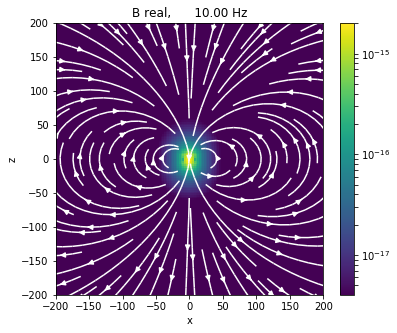

In [148]:
xlim=np.r_[-200., 200]
ylim=np.r_[-200., 200.]

def plot_fields(freq_ind, reim, model): 
    if model == "difference":
        return plot_difference(fields, fields_background, freq_ind, reim=reim, xlim=xlim, ylim=ylim)
    return plot_b(fields if model == "target" else fields_background, freq_ind, reim, xlim, ylim)

ipywidgets.interact(
    plot_fields,
    freq_ind=ipywidgets.IntSlider(min=0, max=len(freqs)-1, value=0), 
    reim=ipywidgets.ToggleButtons(options=['real', 'imag']), 
    model=ipywidgets.ToggleButtons(options=['background', 'target', 'difference']),
)